In [413]:
!pip install transformers

     ---------------------------------------- 0.0/40.2 kB ? eta -:--:--
     ------------------- ------------------ 20.5/40.2 kB 320.0 kB/s eta 0:00:01
     -------------------------------------- 40.2/40.2 kB 318.6 kB/s eta 0:00:00
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   - -------------------------------------- 0.4/10.5 MB 12.2 MB/s eta 0:00:01
   ----- ---------------------------------- 1.6/10.5 MB 20.0 MB/s eta 0:00:01
   --------- ------------------------------ 2.6/10.5 MB 20.6 MB/s eta 0:00:01
   --------------- ------------------------ 4.1/10.5 MB 21.8 MB/s eta 0:00:01
   ------------------- -------------------- 5.1/10.5 MB 23.2 MB/s eta 0:00:01
   ------------------------ --------------- 6.5/10.5 MB 24.5 MB/s eta 0:00:01
   ------------------------------ --------- 8.0/10.5 MB 24.3 MB/s eta 0:00:01
  

In [416]:
!pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   ------- ------------------------------- 61.4/301.2 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 2.7 MB/s eta 0:00:00


In [442]:
!pip install torch>=2.6.0 --upgrade
!pip install safetensors --upgrade
!pip install transformers --upgrade

  You can safely remove it manually.


In [418]:
import pandas as pd
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from wordcloud import WordCloud
import numpy as np

**Data Collection**

In [62]:
mh_df = pd.read_csv("Combined Data.csv")

In [64]:
mh_df.shape

(53043, 3)

In [66]:
mh_df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [68]:
mh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [70]:
mh_df = mh_df.rename(columns={'Unnamed: 0': 'id'})
mh_df

,id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [72]:
#Check for uniqueness in id
mh_df['id'].duplicated().sum()

0

In [74]:
#Sample data from DataFrame
mh_df[['statement', 'status']].sample(20)

,statement,status
18968,I just feel like my life is going no where. I ...,Depression
32358,men singers don't have to look good.,Normal
31700,children seldom visit their parents in a cemet...,Normal
28166,"Needless to say that is all a lie from him, He...",Stress
37998,i just got a new girlfriend we both had sex la...,Depression
39221,now i don t want this to turn into either a po...,Depression
7574,They say suicide is selfish but if i decide wh...,Suicidal
2893,if you can shut up or not,Normal
28872,"Bust the stigma, don't whine but be frank, if ...",Normal
36154,i am looking for someone to talk to all i want...,Suicidal


In [84]:
#Find out average length in statement
mh_df['statement'].str.strip().str.len().max()

32759.0

In [86]:
mh_df['statement'].str.strip().str.len().min()

2.0

In [88]:
mh_df['statement'].str.strip().str.len().mean()

578.6781002638522

In [92]:
mh_df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [96]:
#Look for keywords in rows
mh_df['statement'].str.contains('anxiety|depression|suicide|bipolar|stress|disorder', case=False, na=False).sum()

14830

In [98]:
#Check for null values
mh_df.isna().sum()

id             0
statement    362
status         0
dtype: int64

**Less than 10% of rows are null. Drop these rows.**

In [100]:
mh_df = mh_df.dropna()

In [102]:
mh_df

,id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [104]:
mh_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         52681 non-null  int64 
 1   statement  52681 non-null  object
 2   status     52681 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [106]:
#Check for unique status values
mh_df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

**Check for Outliers**

In [40]:
mh_df['statement'].str.len()

0          10
1          64
2          78
3          61
4          72
         ... 
53038    1766
53039    1012
53040      85
53041     401
53042     417
Name: statement, Length: 52681, dtype: int64

In [44]:
mh_df['statement'].str.len().describe()

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: statement, dtype: float64

In [112]:
mh_df['statement'].str.len().min()

2

In [114]:
mh_df['statement'].str.len().max()

32759

In [124]:
mh_df[mh_df['statement'].str.len() < 3].count()

id           1
statement    1
status       1
dtype: int64

In [130]:
mh_df[mh_df['status'] == 'Bipolar']['statement']

45394    What birth control are you on? I tried an IUD ...
45395    Hypersexuality I was diagnosed with bipolar un...
45396    Meditation I have been using the free meditati...
45397    Family question diagnosis - vent Start with th...
45398    Unable to stop talking to myself- any ideas/ex...
                               ...                        
50649    Head noise, intrusive thoughts, obsessive thin...
50650    recently diagnosed &amp; very anxious when it ...
50651    Puss in Boots: The Last Wish is the best repre...
50652    Stable for years Hey everyone\n\nthanks for ta...
50653    Why are people crapping on coping mechanisms? ...
Name: statement, Length: 2777, dtype: object

In [156]:
#Data Preprocessing
status_to_sentiment = {
    'Depression': 'negative',
    'Anxiety': 'negative',
    'Suicidal': 'negative',
    'Stress' : 'negative',
    'Personality disorder' : 'negative',
    'Normal': 'neutral',
    'Bipolar': 'mixed'  
}

In [158]:
mh_df['sentiment'] = mh_df['status'].map(status_to_sentiment)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16188\3357860801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mh_df['sentiment'] = mh_df['status'].map(status_to_sentiment)


In [160]:
mh_df

,id,statement,status,sentiment
0,0,oh my gosh,Anxiety,negative
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,negative
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,negative
3,3,I've shifted my focus to something else but I'...,Anxiety,negative
4,4,"I'm restless and restless, it's been a month n...",Anxiety,negative
...,...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,negative
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,negative
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety,negative
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,negative


In [162]:
mh_df['sentiment'].value_counts()

sentiment
negative    33561
neutral     16343
mixed        2777
Name: count, dtype: int64

In [164]:
mh_df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [166]:
#List of mental health keywords
mental_health_keywords = [
    # Core / umbrella
    "mental health", "mental illness", "psychological", "psychiatric",
    "emotional health", "well-being", "wellness",

    # Diagnoses & conditions
    "depression", "depressed", "major depressive disorder",
    "anxiety", "generalized anxiety disorder", "social anxiety",
    "panic disorder", "panic attack", "bipolar", "manic", "hypomanic", "mania",
    "borderline personality disorder", "bpd", "personality disorder",
    "ptsd", "post-traumatic stress", "trauma", "ocd", "obsessive compulsive",
    "adhd", "attention-deficit",
    "eating disorder", "anorexia", "bulimia", "binge eating",
    "schizophrenia", "psychosis", "psychotic",

    # Symptoms, feelings & behaviours
    "stress", "worry", "fear", "sadness", "hopelessness", "worthlessness",
    "guilt", "irritability", "fatigue", "insomnia", "restlessness",
    "intrusive thoughts", "flashbacks", "dissociation", "mood swings",
    "self-harm", "cutting", "suicidal", "suicide", "kill myself",
    "end my life", "overdose",

    # Treatments, professionals & supports
    "therapy", "psychotherapy", "counseling", "counsellor", "therapist",
    "psychologist", "psychiatrist",
    "cbt", "cognitive behavioural therapy", "dbt", "dialectical behaviour therapy",
    "mindfulness",
    "medication", "antidepressant", "ssri", "antipsychotic",
    "mood stabilizer", "anxiolytic",
    "inpatient", "outpatient", "crisis hotline", "support group"
]


In [168]:
import re

In [190]:
escaped = map(re.escape, mental_health_keywords)

In [192]:
pattern  = re.compile(r"\b(?:%s)\b" % "|".join(escaped), flags=re.IGNORECASE)

In [194]:
pattern

re.compile(r'\b(?:mental\ health|mental\ illness|psychological|psychiatric|emotional\ health|well\-being|wellness|depression|depressed|major\ depressive\ disorder|anxiety|generalized\ anxiety\ disorder|social\ anxiety|panic\ disorder|panic\ attack|bipolar|manic|hypomanic|mania|borderline\ personality\ disorder|bpd|personality\ disorder|ptsd|post\-traumatic\ stress|trauma|ocd|obsessive\ compulsive|adhd|attention\-deficit|eating\ disorder|anorexia|bulimia|binge\ eating|schizophrenia|psychosis|psychotic|stress|worry|fear|sadness|hopelessness|worthlessness|guilt|irritability|fatigue|insomnia|restlessness|intrusive\ thoughts|flashbacks|dissociation|mood\ swings|self\-harm|cutting|suicidal|suicide|kill\ myself|end\ my\ life|overdose|therapy|psychotherapy|counseling|counsellor|therapist|psychologist|psychiatrist|cbt|cognitive\ behavioural\ therapy|dbt|dialectical\ behaviour\ therapy|mindfulness|medication|antidepressant|ssri|antipsychotic|mood\ stabilizer|anxiolytic|inpatient|outpatient|crisi

In [206]:
mask = mh_df["statement"].str.contains(pattern, na=False) 

In [200]:
#Filter dataframe as per keywords
filtered_mh_df = mh_df[mask]

In [202]:
filtered_mh_df

,id,statement,status,sentiment
13,13,Because this worry is you.,Anxiety,negative
21,21,Successfully online at 9am. Even sleeping in a...,Anxiety,negative
30,30,"I'm broken and fragile, I'm hurt, I can't stan...",Anxiety,negative
31,31,"# Suggest a song that makes you calm, don't kn...",Anxiety,negative
36,36,"Tonight he continues to chatter about money, I...",Anxiety,negative
...,...,...,...,...
53037,53037,Lorazepam side effect/after effect In the last...,Anxiety,negative
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,negative
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,negative
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,negative


**Step 2: Data Cleaning and Preprocessing.**

In [208]:
filtered_mh_df.isna().sum()

id           0
statement    0
status       0
sentiment    0
dtype: int64

In [210]:
filtered_mh_df['id'].duplicated().sum()

0

In [263]:
filtered_mh_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22256 entries, 13 to 53042
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         22256 non-null  int64 
 1   statement  22256 non-null  object
 2   status     22256 non-null  object
 3   sentiment  22256 non-null  object
dtypes: int64(1), object(3)
memory usage: 869.4+ KB


In [265]:
filtered_mh_df['statement'].duplicated().sum()

920

In [267]:
filtered_mh_df[filtered_mh_df['statement'].duplicated()]

,id,statement,status,sentiment
167,167,I want to exhale the restlessness in my chest ...,Anxiety,negative
304,304,Restless restlessness accompanies,Anxiety,negative
367,367,I want to exhale the restlessness in my chest ...,Anxiety,negative
3000,3000,It's the fear of losing that makes me jealous ...,Normal,neutral
3605,3605,It's the fear of losing that makes me jealous ...,Normal,neutral
...,...,...,...,...
53037,53037,Lorazepam side effect/after effect In the last...,Anxiety,negative
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,negative
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,negative
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,negative


In [269]:
filtered_mh_df_clean = filtered_mh_df.drop_duplicates(subset = "statement", keep=False, ignore_index=True)

In [271]:
filtered_mh_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20461 entries, 0 to 20460
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20461 non-null  int64 
 1   statement  20461 non-null  object
 2   status     20461 non-null  object
 3   sentiment  20461 non-null  object
dtypes: int64(1), object(3)
memory usage: 639.5+ KB


In [273]:
#Convert statement to lower case
filtered_mh_df_clean['statement'] = filtered_mh_df_clean['statement'].str.lower()

C:\Users\Dell\AppData\Local\Temp\ipykernel_16188\1159168785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mh_df_clean['statement'] = filtered_mh_df_clean['statement'].str.lower()


In [275]:
regex = re.compile(
    r"""(
        http\S+            |   # URLs (http, https, ftp…)
        www\.\S+           |   # URLs starting with www.
        @\w+               |   # Twitter-style mentions
        #\w+               |   # hashtags
        [^\w\s]            |   # punctuation / special chars
        \d+                    # numbers
    )""",
    flags=re.IGNORECASE | re.VERBOSE,
)

In [279]:
filtered_mh_df_clean["statement_clean"] = (
    filtered_mh_df_clean["statement"]
      .str.replace(regex, " ", regex=True)      # strip the unwanted tokens
      .str.lower()                              # optional: lowercase
      .str.replace(r"\s+", " ", regex=True)     # collapse repeated spaces
      .str.strip()                              # trim leading / trailing space
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16188\919018972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mh_df_clean["statement_clean"] = (


In [281]:
filtered_mh_df_clean

,id,statement,status,sentiment,statement_clean
0,13,because this worry is you.,Anxiety,negative,because this worry is you
1,21,successfully online at 9am. even sleeping in a...,Anxiety,negative,successfully online at am even sleeping in a s...
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",Anxiety,negative,i m broken and fragile i m hurt i can t stand ...
3,31,"# suggest a song that makes you calm, don't kn...",Anxiety,negative,suggest a song that makes you calm don t know ...
4,36,"tonight he continues to chatter about money, i...",Anxiety,negative,tonight he continues to chatter about money i ...
...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,Anxiety,negative,anxiety progress my story hey guys i ve been f...
20457,52835,anxiety cause faintness when standing up ? as ...,Anxiety,negative,anxiety cause faintness when standing up as ti...
20458,52836,anxiety heart symptom does anyone else have th...,Anxiety,negative,anxiety heart symptom does anyone else have th...
20459,52837,travel anxiety hi all! long time anxiety suffe...,Anxiety,negative,travel anxiety hi all long time anxiety suffer...


In [296]:
filtered_mh_df_clean['status'].value_counts()

status
Depression              9422
Suicidal                5594
Anxiety                 2001
Bipolar                 1785
Stress                   951
Normal                   405
Personality disorder     303
Name: count, dtype: int64

In [300]:
filtered_mh_df_clean.isna().sum()

id                 0
statement          0
status             0
sentiment          0
statement_clean    0
dtype: int64

**Preprocess Text for NLP**

In [286]:
import nltk

In [290]:
nltk.download("stopwords")   # list of stop words
nltk.download("wordnet")     # WordNet database
nltk.download("omw-1.4")     # word-sense mappings (needed by lemmatizer)
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [304]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [308]:
filtered_mh_df_clean["tokens"] = filtered_mh_df_clean["statement_clean"].apply(lambda txt: word_tokenize(txt, language="english", preserve_line=False))

C:\Users\Dell\AppData\Local\Temp\ipykernel_16188\370659477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mh_df_clean["tokens"] = filtered_mh_df_clean["statement_clean"].apply(lambda txt: word_tokenize(txt, language="english", preserve_line=False))


In [310]:
filtered_mh_df_clean

,id,statement,status,sentiment,statement_clean,tokens
0,13,because this worry is you.,Anxiety,negative,because this worry is you,"[because, this, worry, is, you]"
1,21,successfully online at 9am. even sleeping in a...,Anxiety,negative,successfully online at am even sleeping in a s...,"[successfully, online, at, am, even, sleeping,..."
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",Anxiety,negative,i m broken and fragile i m hurt i can t stand ...,"[i, m, broken, and, fragile, i, m, hurt, i, ca..."
3,31,"# suggest a song that makes you calm, don't kn...",Anxiety,negative,suggest a song that makes you calm don t know ...,"[suggest, a, song, that, makes, you, calm, don..."
4,36,"tonight he continues to chatter about money, i...",Anxiety,negative,tonight he continues to chatter about money i ...,"[tonight, he, continues, to, chatter, about, m..."
...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,Anxiety,negative,anxiety progress my story hey guys i ve been f...,"[anxiety, progress, my, story, hey, guys, i, v..."
20457,52835,anxiety cause faintness when standing up ? as ...,Anxiety,negative,anxiety cause faintness when standing up as ti...,"[anxiety, cause, faintness, when, standing, up..."
20458,52836,anxiety heart symptom does anyone else have th...,Anxiety,negative,anxiety heart symptom does anyone else have th...,"[anxiety, heart, symptom, does, anyone, else, ..."
20459,52837,travel anxiety hi all! long time anxiety suffe...,Anxiety,negative,travel anxiety hi all long time anxiety suffer...,"[travel, anxiety, hi, all, long, time, anxiety..."


In [314]:
stop_words = set(stopwords.words('english')) - {"not", "no"}

In [320]:
#Remove stopwords from tokens and lemmatize them
def stop(token_list):
    filtered_sentence = [w for w in token_list if w.lower() not in stop_words]
    return filtered_sentence
filtered_mh_df_clean['tokens_stop'] = filtered_mh_df_clean['tokens'].apply(stop)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16188\3146067492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mh_df_clean['tokens_stop'] = filtered_mh_df_clean['tokens'].apply(stop)


In [321]:
filtered_mh_df_clean

,id,statement,status,sentiment,statement_clean,tokens,tokens_stop
0,13,because this worry is you.,Anxiety,negative,because this worry is you,"[because, this, worry, is, you]",[worry]
1,21,successfully online at 9am. even sleeping in a...,Anxiety,negative,successfully online at am even sleeping in a s...,"[successfully, online, at, am, even, sleeping,...","[successfully, online, even, sleeping, state, ..."
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",Anxiety,negative,i m broken and fragile i m hurt i can t stand ...,"[i, m, broken, and, fragile, i, m, hurt, i, ca...","[broken, fragile, hurt, stand, anxiety, anymor..."
3,31,"# suggest a song that makes you calm, don't kn...",Anxiety,negative,suggest a song that makes you calm don t know ...,"[suggest, a, song, that, makes, you, calm, don...","[suggest, song, makes, calm, know, suddenly, f..."
4,36,"tonight he continues to chatter about money, i...",Anxiety,negative,tonight he continues to chatter about money i ...,"[tonight, he, continues, to, chatter, about, m...","[tonight, continues, chatter, money, confused,..."
...,...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,Anxiety,negative,anxiety progress my story hey guys i ve been f...,"[anxiety, progress, my, story, hey, guys, i, v...","[anxiety, progress, story, hey, guys, followin..."
20457,52835,anxiety cause faintness when standing up ? as ...,Anxiety,negative,anxiety cause faintness when standing up as ti...,"[anxiety, cause, faintness, when, standing, up...","[anxiety, cause, faintness, standing, title, a..."
20458,52836,anxiety heart symptom does anyone else have th...,Anxiety,negative,anxiety heart symptom does anyone else have th...,"[anxiety, heart, symptom, does, anyone, else, ...","[anxiety, heart, symptom, anyone, else, someth..."
20459,52837,travel anxiety hi all! long time anxiety suffe...,Anxiety,negative,travel anxiety hi all long time anxiety suffer...,"[travel, anxiety, hi, all, long, time, anxiety...","[travel, anxiety, hi, long, time, anxiety, suf..."


In [328]:
def lemma(token_list):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(tok, pos="v") for tok in token_list]

filtered_mh_df_clean['tokens_clean'] = filtered_mh_df_clean['tokens_stop'].apply(lemma)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16188\3630512205.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_mh_df_clean['tokens_clean'] = filtered_mh_df_clean['tokens_stop'].apply(lemma)


In [329]:
filtered_mh_df_clean

,id,statement,status,sentiment,statement_clean,tokens,tokens_stop,tokens_clean
0,13,because this worry is you.,Anxiety,negative,because this worry is you,"[because, this, worry, is, you]",[worry],[worry]
1,21,successfully online at 9am. even sleeping in a...,Anxiety,negative,successfully online at am even sleeping in a s...,"[successfully, online, at, am, even, sleeping,...","[successfully, online, even, sleeping, state, ...","[successfully, online, even, sleep, state, res..."
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",Anxiety,negative,i m broken and fragile i m hurt i can t stand ...,"[i, m, broken, and, fragile, i, m, hurt, i, ca...","[broken, fragile, hurt, stand, anxiety, anymor...","[break, fragile, hurt, stand, anxiety, anymore..."
3,31,"# suggest a song that makes you calm, don't kn...",Anxiety,negative,suggest a song that makes you calm don t know ...,"[suggest, a, song, that, makes, you, calm, don...","[suggest, song, makes, calm, know, suddenly, f...","[suggest, song, make, calm, know, suddenly, fe..."
4,36,"tonight he continues to chatter about money, i...",Anxiety,negative,tonight he continues to chatter about money i ...,"[tonight, he, continues, to, chatter, about, m...","[tonight, continues, chatter, money, confused,...","[tonight, continue, chatter, money, confuse, s..."
...,...,...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,Anxiety,negative,anxiety progress my story hey guys i ve been f...,"[anxiety, progress, my, story, hey, guys, i, v...","[anxiety, progress, story, hey, guys, followin...","[anxiety, progress, story, hey, guy, follow, c..."
20457,52835,anxiety cause faintness when standing up ? as ...,Anxiety,negative,anxiety cause faintness when standing up as ti...,"[anxiety, cause, faintness, when, standing, up...","[anxiety, cause, faintness, standing, title, a...","[anxiety, cause, faintness, stand, title, anxi..."
20458,52836,anxiety heart symptom does anyone else have th...,Anxiety,negative,anxiety heart symptom does anyone else have th...,"[anxiety, heart, symptom, does, anyone, else, ...","[anxiety, heart, symptom, anyone, else, someth...","[anxiety, heart, symptom, anyone, else, someth..."
20459,52837,travel anxiety hi all! long time anxiety suffe...,Anxiety,negative,travel anxiety hi all long time anxiety suffer...,"[travel, anxiety, hi, all, long, time, anxiety...","[travel, anxiety, hi, long, time, anxiety, suf...","[travel, anxiety, hi, long, time, anxiety, suf..."


In [332]:
filtered_mh_df_clean = filtered_mh_df_clean.drop(['tokens', 'tokens_stop'], axis = 1)

In [334]:
filtered_mh_df_clean

,id,statement,status,sentiment,statement_clean,tokens_clean
0,13,because this worry is you.,Anxiety,negative,because this worry is you,[worry]
1,21,successfully online at 9am. even sleeping in a...,Anxiety,negative,successfully online at am even sleeping in a s...,"[successfully, online, even, sleep, state, res..."
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",Anxiety,negative,i m broken and fragile i m hurt i can t stand ...,"[break, fragile, hurt, stand, anxiety, anymore..."
3,31,"# suggest a song that makes you calm, don't kn...",Anxiety,negative,suggest a song that makes you calm don t know ...,"[suggest, song, make, calm, know, suddenly, fe..."
4,36,"tonight he continues to chatter about money, i...",Anxiety,negative,tonight he continues to chatter about money i ...,"[tonight, continue, chatter, money, confuse, s..."
...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,Anxiety,negative,anxiety progress my story hey guys i ve been f...,"[anxiety, progress, story, hey, guy, follow, c..."
20457,52835,anxiety cause faintness when standing up ? as ...,Anxiety,negative,anxiety cause faintness when standing up as ti...,"[anxiety, cause, faintness, stand, title, anxi..."
20458,52836,anxiety heart symptom does anyone else have th...,Anxiety,negative,anxiety heart symptom does anyone else have th...,"[anxiety, heart, symptom, anyone, else, someth..."
20459,52837,travel anxiety hi all! long time anxiety suffe...,Anxiety,negative,travel anxiety hi all long time anxiety suffer...,"[travel, anxiety, hi, long, time, anxiety, suf..."


In [338]:
mh_df_final = filtered_mh_df_clean[['id', 'statement', 'statement_clean', 'tokens_clean', 'status', 'sentiment']]
mh_df_final

,id,statement,statement_clean,tokens_clean,status,sentiment
0,13,because this worry is you.,because this worry is you,[worry],Anxiety,negative
1,21,successfully online at 9am. even sleeping in a...,successfully online at am even sleeping in a s...,"[successfully, online, even, sleep, state, res...",Anxiety,negative
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",i m broken and fragile i m hurt i can t stand ...,"[break, fragile, hurt, stand, anxiety, anymore...",Anxiety,negative
3,31,"# suggest a song that makes you calm, don't kn...",suggest a song that makes you calm don t know ...,"[suggest, song, make, calm, know, suddenly, fe...",Anxiety,negative
4,36,"tonight he continues to chatter about money, i...",tonight he continues to chatter about money i ...,"[tonight, continue, chatter, money, confuse, s...",Anxiety,negative
...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,anxiety progress my story hey guys i ve been f...,"[anxiety, progress, story, hey, guy, follow, c...",Anxiety,negative
20457,52835,anxiety cause faintness when standing up ? as ...,anxiety cause faintness when standing up as ti...,"[anxiety, cause, faintness, stand, title, anxi...",Anxiety,negative
20458,52836,anxiety heart symptom does anyone else have th...,anxiety heart symptom does anyone else have th...,"[anxiety, heart, symptom, anyone, else, someth...",Anxiety,negative
20459,52837,travel anxiety hi all! long time anxiety suffe...,travel anxiety hi all long time anxiety suffer...,"[travel, anxiety, hi, long, time, anxiety, suf...",Anxiety,negative


In [342]:
def join_tok(tok_list):
    return " ".join(tok_list)
mh_df_final['tokens_clean'] = mh_df_final['tokens_clean'].apply(join_tok)

In [344]:
mh_df_final

,id,statement,statement_clean,tokens_clean,status,sentiment
0,13,because this worry is you.,because this worry is you,worry,Anxiety,negative
1,21,successfully online at 9am. even sleeping in a...,successfully online at am even sleeping in a s...,successfully online even sleep state restlessn...,Anxiety,negative
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",i m broken and fragile i m hurt i can t stand ...,break fragile hurt stand anxiety anymore stand...,Anxiety,negative
3,31,"# suggest a song that makes you calm, don't kn...",suggest a song that makes you calm don t know ...,suggest song make calm know suddenly feel ange...,Anxiety,negative
4,36,"tonight he continues to chatter about money, i...",tonight he continues to chatter about money i ...,tonight continue chatter money confuse say wor...,Anxiety,negative
...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,anxiety progress my story hey guys i ve been f...,anxiety progress story hey guy follow communit...,Anxiety,negative
20457,52835,anxiety cause faintness when standing up ? as ...,anxiety cause faintness when standing up as ti...,anxiety cause faintness stand title anxiety ca...,Anxiety,negative
20458,52836,anxiety heart symptom does anyone else have th...,anxiety heart symptom does anyone else have th...,anxiety heart symptom anyone else something si...,Anxiety,negative
20459,52837,travel anxiety hi all! long time anxiety suffe...,travel anxiety hi all long time anxiety suffer...,travel anxiety hi long time anxiety sufferer f...,Anxiety,negative


In [346]:
mh_df_final['tokens_clean'].str.split().str.len().mean()

90.43321440789795

In [350]:
mh_df_final['tokens_clean'].str.split().str.len()

0          1
1          7
2         20
3         11
4         11
        ... 
20456    208
20457     12
20458     30
20459     79
20460     30
Name: tokens_clean, Length: 20461, dtype: int64

Check for outliers

In [380]:
mh_df_final[mh_df_final['tokens_clean'].str.split().str.len() < 3].count()

id                 47
statement          47
statement_clean    47
tokens_clean       47
status             47
sentiment          47
dtype: int64

In [384]:
mh_df_final[mh_df_final['tokens_clean'].str.split().str.len() > 100].count()

id                 6212
statement          6212
statement_clean    6212
tokens_clean       6212
status             6212
sentiment          6212
dtype: int64

In [387]:
mh_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20461 entries, 0 to 20460
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               20461 non-null  int64 
 1   statement        20461 non-null  object
 2   statement_clean  20461 non-null  object
 3   tokens_clean     20461 non-null  object
 4   status           20461 non-null  object
 5   sentiment        20461 non-null  object
dtypes: int64(1), object(5)
memory usage: 959.2+ KB


Check for null values

In [389]:
mh_df_final.isna().sum()

id                 0
statement          0
statement_clean    0
tokens_clean       0
status             0
sentiment          0
dtype: int64

In [395]:
mh_df_final['id'].duplicated().sum()

0

In [401]:
mh_df_final['tokens_clean'].duplicated().sum()

20

In [407]:
mh_df_final['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [409]:
mh_df_final['sentiment'].unique()

array(['negative', 'neutral', 'mixed'], dtype=object)

In [420]:
# Ensure NLTK data is downloaded
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [422]:
# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('docs', exist_ok=True)

In [424]:
# Use mh_df_final as the DataFrame
df = mh_df_final.copy()  # Copy to avoid modifying original

In [426]:
# Step 3: Sentiment and Emotion Analysis
print("Step 3: Sentiment and Emotion Analysis")

Step 3: Sentiment and Emotion Analysis


In [428]:
# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Apply VADER to tokens_clean
df['vader_score'] = df['tokens_clean'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['vader_sentiment'] = df['vader_score'].apply(lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral')

In [430]:
df

,id,statement,statement_clean,tokens_clean,status,sentiment,vader_score,vader_sentiment
0,13,because this worry is you.,because this worry is you,worry,Anxiety,negative,-0.4404,negative
1,21,successfully online at 9am. even sleeping in a...,successfully online at am even sleeping in a s...,successfully online even sleep state restlessn...,Anxiety,negative,-0.2732,negative
2,30,"i'm broken and fragile, i'm hurt, i can't stan...",i m broken and fragile i m hurt i can t stand ...,break fragile hurt stand anxiety anymore stand...,Anxiety,negative,-0.5550,negative
3,31,"# suggest a song that makes you calm, don't kn...",suggest a song that makes you calm don t know ...,suggest song make calm know suddenly feel ange...,Anxiety,negative,-0.2732,negative
4,36,"tonight he continues to chatter about money, i...",tonight he continues to chatter about money i ...,tonight continue chatter money confuse say wor...,Anxiety,negative,-0.5859,negative
...,...,...,...,...,...,...,...,...
20456,52834,anxiety progress/my story hey guys! \n\ni’ve b...,anxiety progress my story hey guys i ve been f...,anxiety progress story hey guy follow communit...,Anxiety,negative,0.9796,positive
20457,52835,anxiety cause faintness when standing up ? as ...,anxiety cause faintness when standing up as ti...,anxiety cause faintness stand title anxiety ca...,Anxiety,negative,-0.3400,negative
20458,52836,anxiety heart symptom does anyone else have th...,anxiety heart symptom does anyone else have th...,anxiety heart symptom anyone else something si...,Anxiety,negative,0.7506,positive
20459,52837,travel anxiety hi all! long time anxiety suffe...,travel anxiety hi all long time anxiety suffer...,travel anxiety hi long time anxiety sufferer f...,Anxiety,negative,-0.9579,negative


In [446]:
!pip install textblob --upgrade

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
    --------------------------------------- 10.2/624.3 kB ? eta -:--:--
   --- ----------------------------------- 61.4/624.3 kB 812.7 kB/s eta 0:00:01
   -------------------------------- ------- 512.0/624.3 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 4.9 MB/s eta 0:00:00
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [448]:
# Apply TextBlob for emotion analysis
from textblob import TextBlob

def get_emotion(text, status):
    try:
        if len(text.strip()) > 0:  # Ensure non-empty text
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            if polarity > 0.1:
                return 'happy', polarity
            elif polarity < -0.1:
                if status in ['Anxiety', 'Stress']:  # Map to fear for anxiety/stress
                    return 'fear', abs(polarity)
                else:  # Default to sad for Depression, Suicidal, etc.
                    return 'sad', abs(polarity)
            else:
                return 'neutral', abs(polarity)
        else:
            return 'unknown', 0.0
    except:
        return 'unknown', 0.0

# Apply emotion analysis to tokens_clean
df[['emotion', 'emotion_score']] = df.apply(
    lambda x: get_emotion(x['tokens_clean'], x['status']), 
    axis=1, 
    result_type='expand'
)

In [450]:
# Validate sentiment
# Handle mixed sentiment by mapping to neutral for comparison
df['sentiment_for_validation'] = df['sentiment'].replace('mixed', 'neutral')
accuracy = accuracy_score(df['vader_sentiment'], df['sentiment_for_validation'])
conf_matrix = confusion_matrix(df['vader_sentiment'], df['sentiment_for_validation'], labels=['positive', 'negative', 'neutral'])

# Manual inspection
print("Sentiment validation sample:")
print(df[['tokens_clean', 'vader_sentiment', 'sentiment']].sample(10))
print(f"Sentiment accuracy: {accuracy:.2f}")
print("Confusion matrix:\n", conf_matrix)

# Emotion validation
print("Emotion validation sample:")
print(df[['tokens_clean', 'emotion', 'emotion_score']].sample(10))
print("Emotion distribution:\n", df['emotion'].value_counts())

Sentiment validation sample:
                                            tokens_clean vader_sentiment  \
311    life hard pain time work heal years improvemen...        negative   
8800   hey guy feel like turn point scar always okay ...        positive   
12054  worst anxiety life recently college student fa...        negative   
14156  dont know keep try home life always incredibly...        negative   
19717  affront world edit not native directly transla...        negative   
5016   everything suck unhappy relationship fully con...        negative   
6860   graduate college wonderful opportunity move we...        negative   
13202  ever feel like break anxiety minute come right...        negative   
4949   recently plague violent thoughts leave exhaust...        negative   
1355   serious worst person family six people direct ...        negative   

      sentiment  
311    negative  
8800   negative  
12054  negative  
14156  negative  
19717  negative  
5016   negative  
6860   n

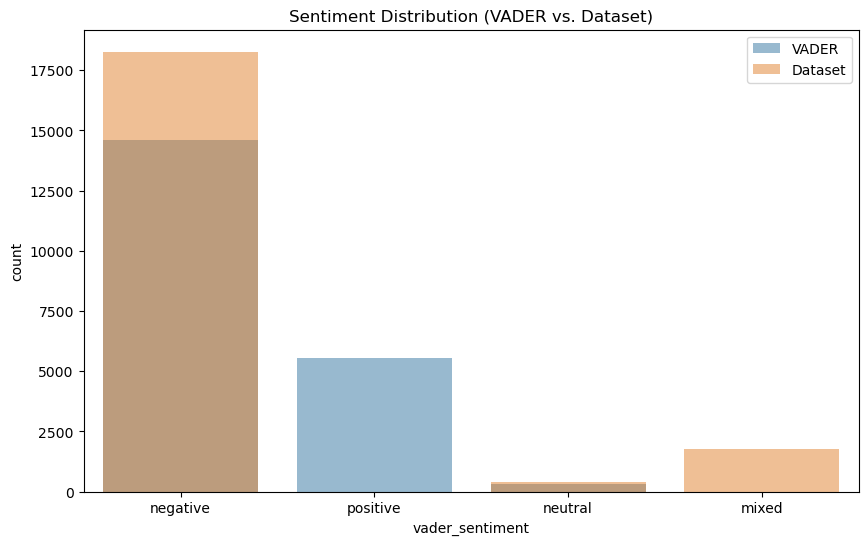

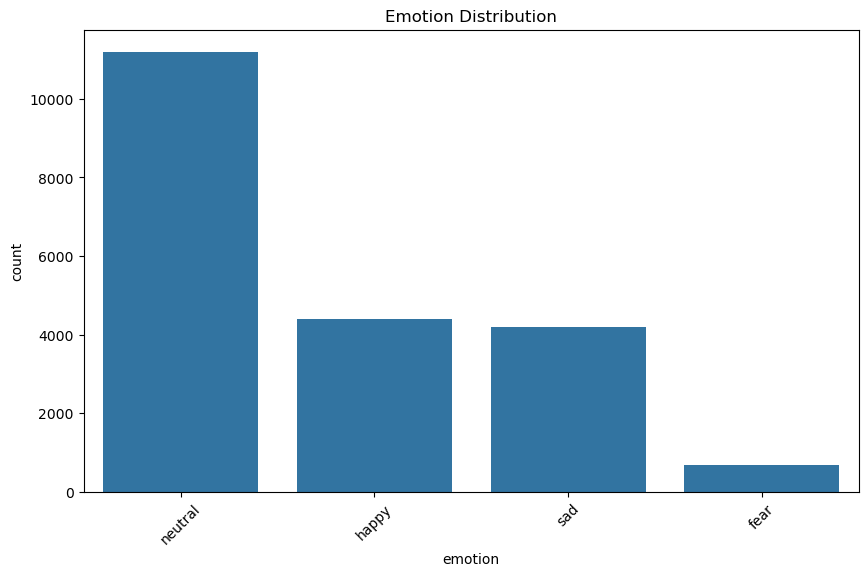

In [454]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='vader_sentiment', label='VADER', alpha=0.5)
sns.countplot(data=df, x='sentiment', label='Dataset', alpha=0.5)
plt.title('Sentiment Distribution (VADER vs. Dataset)')
plt.legend()
plt.savefig('sentiment_distribution.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title('Emotion Distribution')
plt.xticks(rotation=45)
plt.savefig('emotion_distribution.png', bbox_inches='tight')
plt.show()

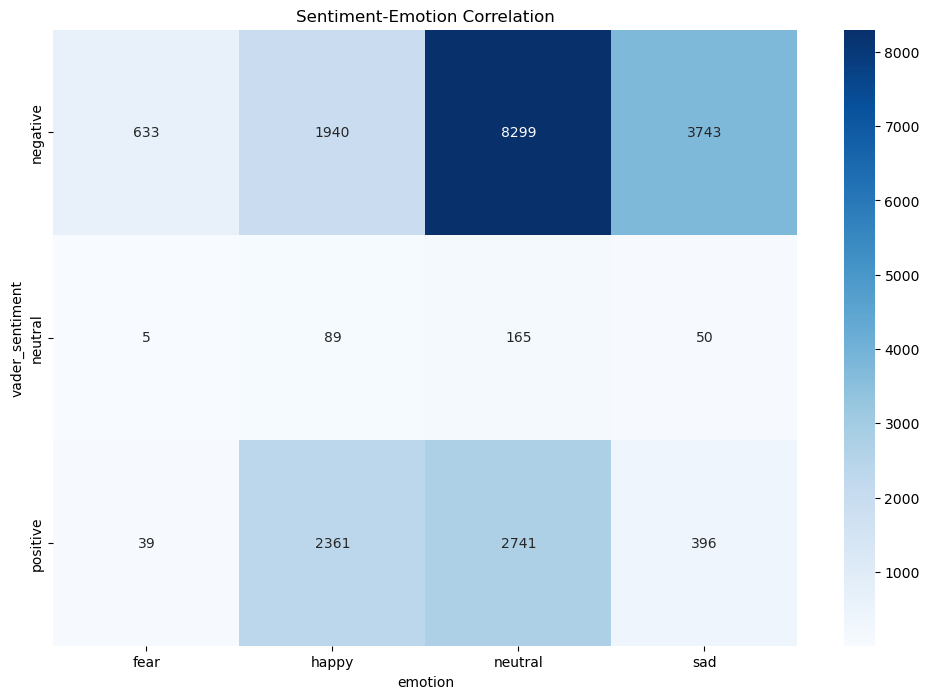

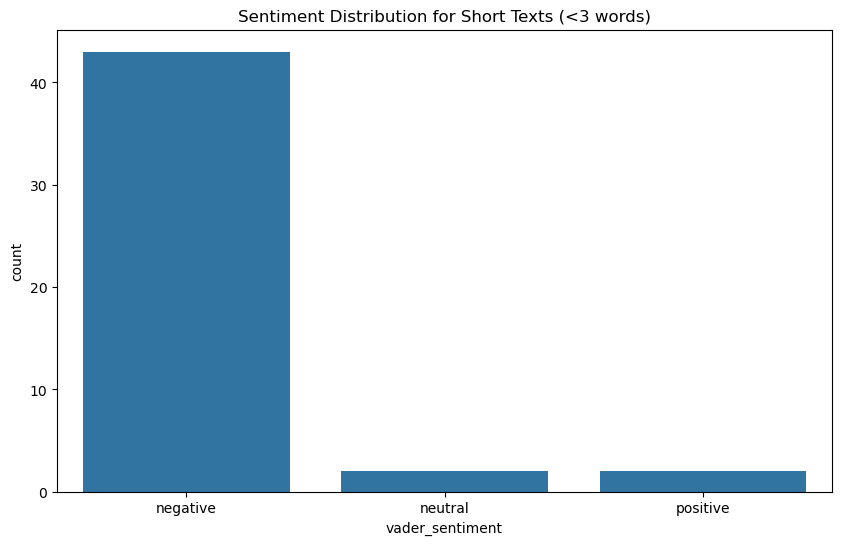

Step 3 completed: Saved posts_sentiment.csv


In [456]:
# Sentiment-emotion correlation
sent_emotion = df.groupby(['vader_sentiment', 'emotion']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(sent_emotion, annot=True, fmt='d', cmap='Blues')
plt.title('Sentiment-Emotion Correlation')
plt.savefig('sentiment_emotion_correlation.png', bbox_inches='tight')
plt.show()

# Short text impact
short_texts = df[df['tokens_clean'].str.split().str.len() < 3]
plt.figure(figsize=(10, 6))
sns.countplot(data=short_texts, x='vader_sentiment')
plt.title('Sentiment Distribution for Short Texts (<3 words)')
plt.savefig('short_text_sentiment.png', bbox_inches='tight')
plt.show()

# Save results
df.to_csv('posts_sentiment.csv', index=False)
print("Step 3 completed: Saved posts_sentiment.csv")

In [458]:
# Step 4: Topic Modeling
print("Step 4: Topic Modeling")

Step 4: Topic Modeling


In [460]:
# Prepare TF-IDF matrix
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['tokens_clean'])
feature_names = vectorizer.get_feature_names_out()

In [462]:
# Train LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [464]:
# Assign topics
topic_probs = lda.transform(tfidf_matrix)
df['topic'] = topic_probs.argmax(axis=1)

# Label topics based on top words
topic_labels = []
for i in range(n_topics):
    top_words = [feature_names[idx] for idx in lda.components_[i].argsort()[-10:][::-1]]
    label = f"Topic {i+1}: {', '.join(top_words[:3])}"
    topic_labels.append(label)
topic_mapping = {i: label for i, label in enumerate(topic_labels)}
df['topic_label'] = df['topic'].map(topic_mapping)

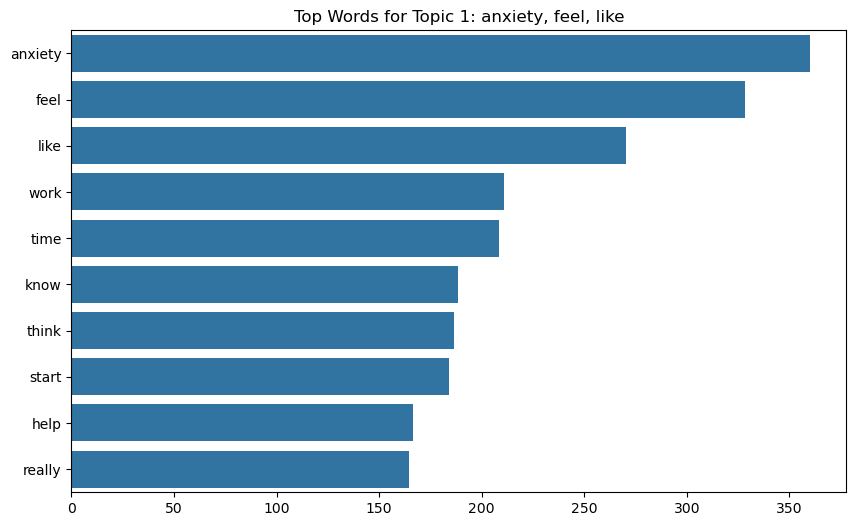

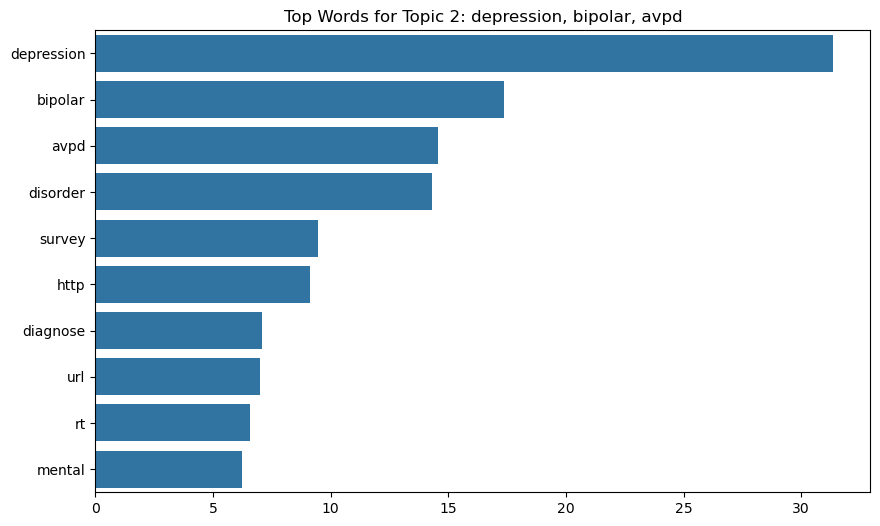

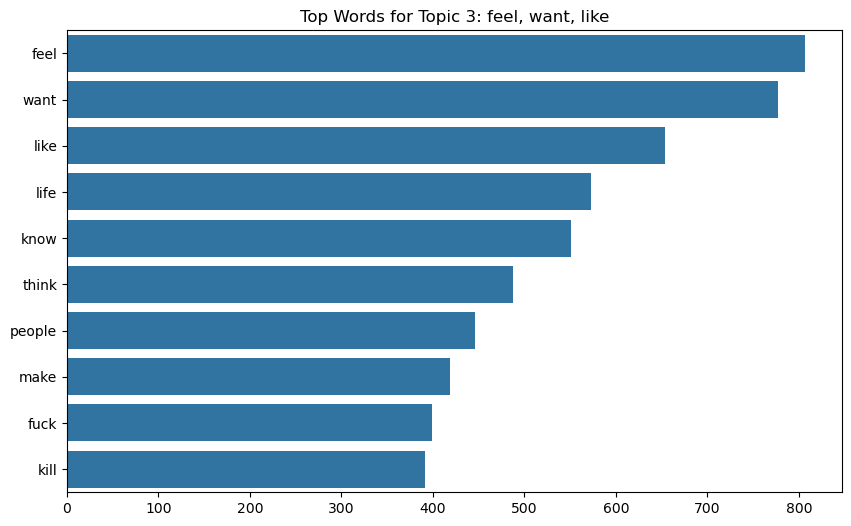

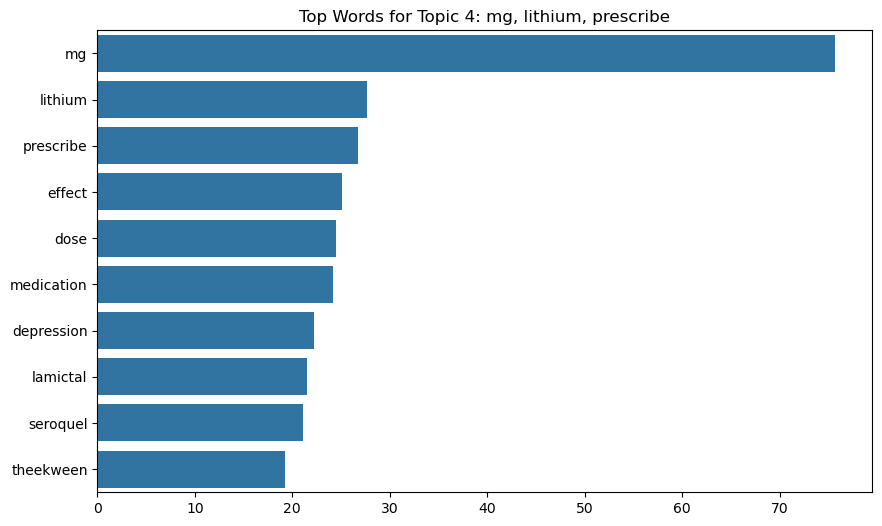

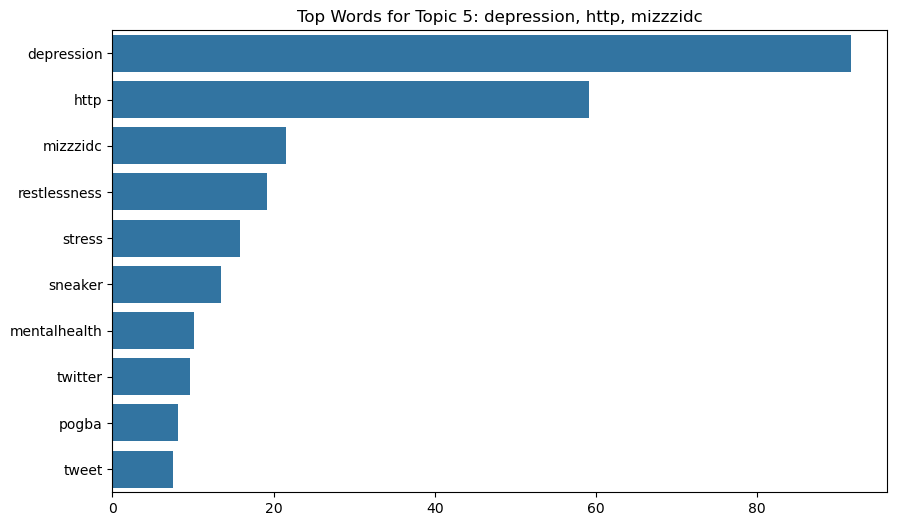

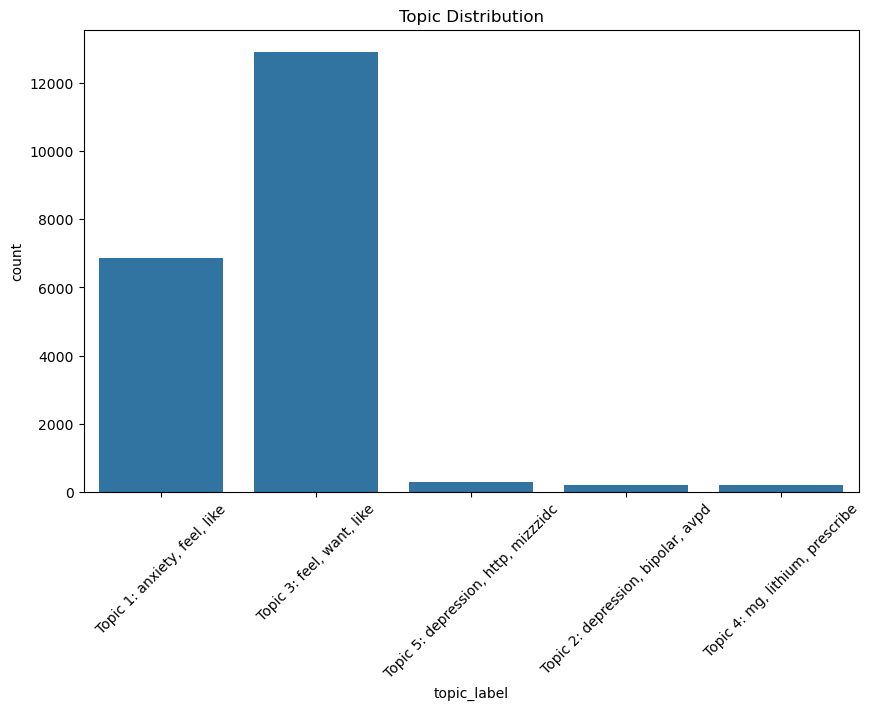

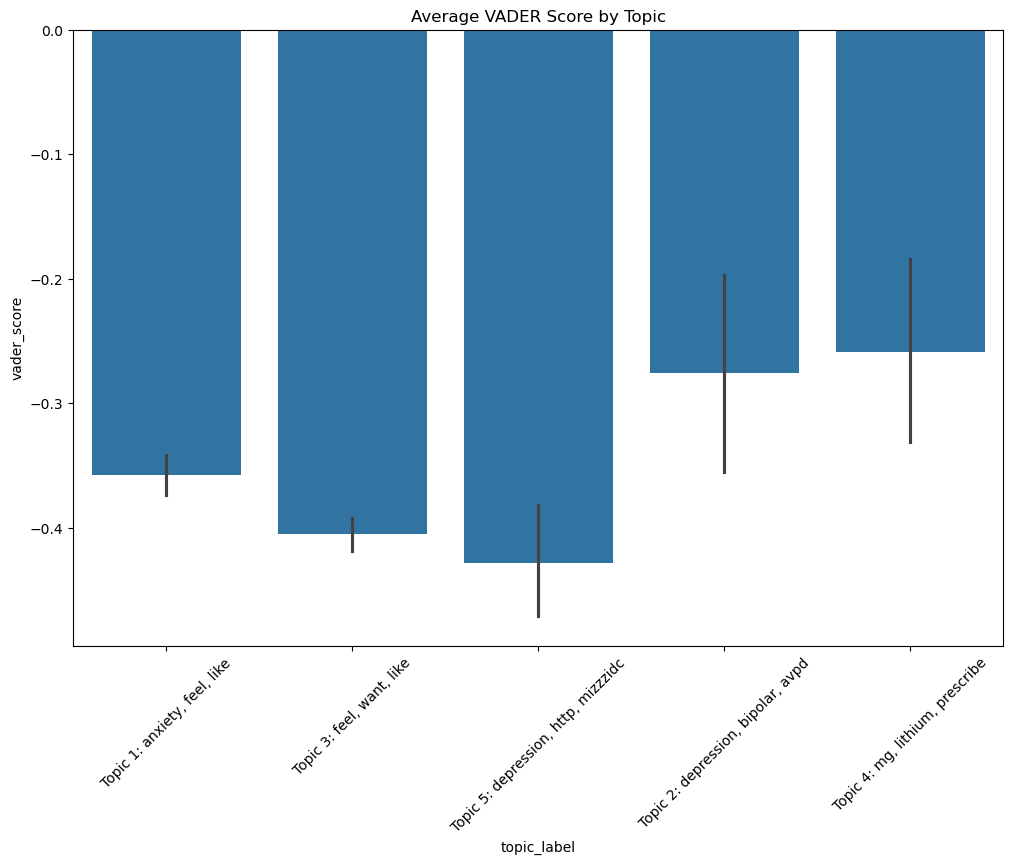

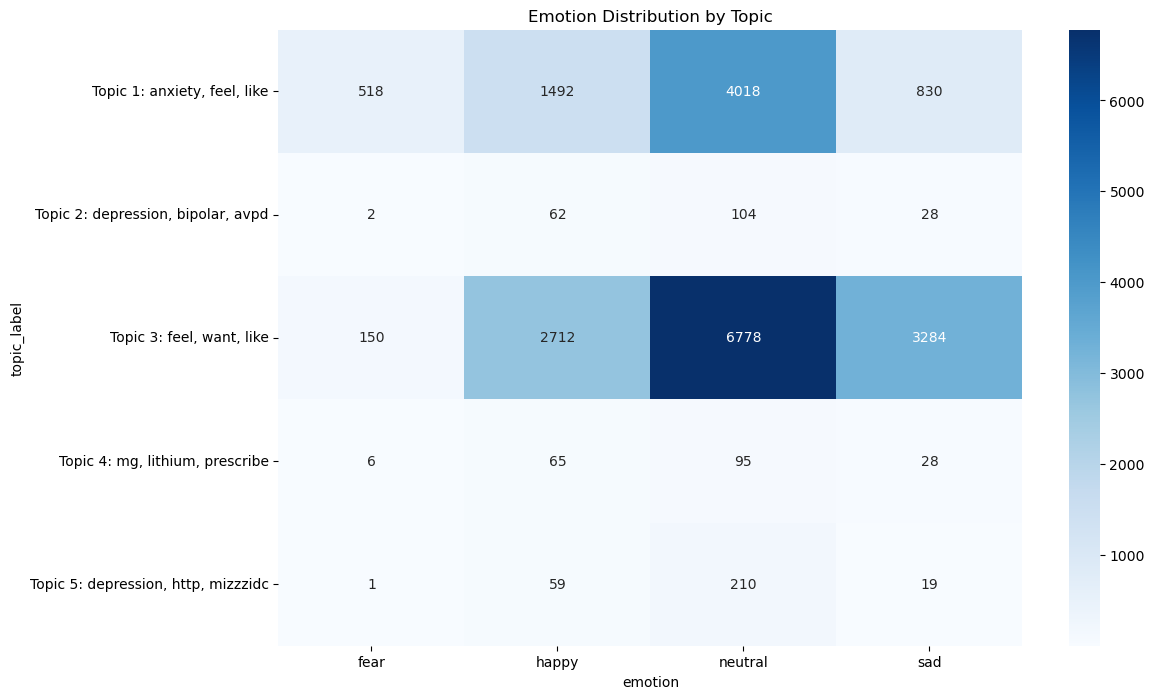

Step 4 completed: Saved posts_topics.csv


In [466]:
# Visualizations
# Top words per topic
for i in range(n_topics):
    top_words = [feature_names[idx] for idx in lda.components_[i].argsort()[-10:][::-1]]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[lda.components_[i][vectorizer.vocabulary_[word]] for word in top_words], y=top_words)
    plt.title(f'Top Words for {topic_labels[i]}')
    plt.savefig(f'topic_words_{i+1}.png', bbox_inches='tight')
    plt.show()

# Topic distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='topic_label')
plt.title('Topic Distribution')
plt.xticks(rotation=45)
plt.savefig('topic_distribution.png', bbox_inches='tight')
plt.show()

# Topic-sentiment/emotion
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='topic_label', y='vader_score')
plt.title('Average VADER Score by Topic')
plt.xticks(rotation=45)
plt.savefig('topic_sentiment.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
topic_emotion = df.groupby(['topic_label', 'emotion']).size().unstack(fill_value=0)
sns.heatmap(topic_emotion, annot=True, fmt='d', cmap='Blues')
plt.title('Emotion Distribution by Topic')
plt.savefig('topic_emotion.png', bbox_inches='tight')
plt.show()

# Save results
df.to_csv('data/posts_topics.csv', index=False)
print("Step 4 completed: Saved posts_topics.csv")

In [468]:
# Step 5: Thematic Analysis
print("Step 5: Thematic Analysis")

Step 5: Thematic Analysis


<Figure size 1200x800 with 0 Axes>

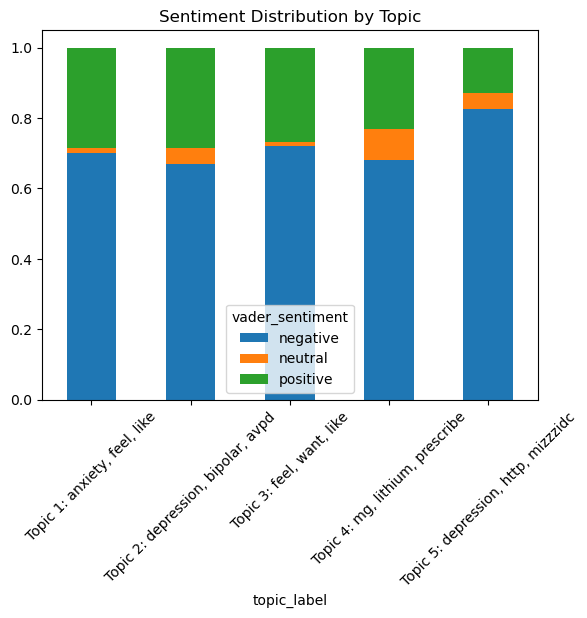

In [470]:
# Sentiment by topic
sentiment_by_topic = df.groupby('topic_label')['vader_sentiment'].value_counts(normalize=True).unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sentiment_by_topic.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Topic')
plt.xticks(rotation=45)
plt.savefig('sentiment_by_topic.png', bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

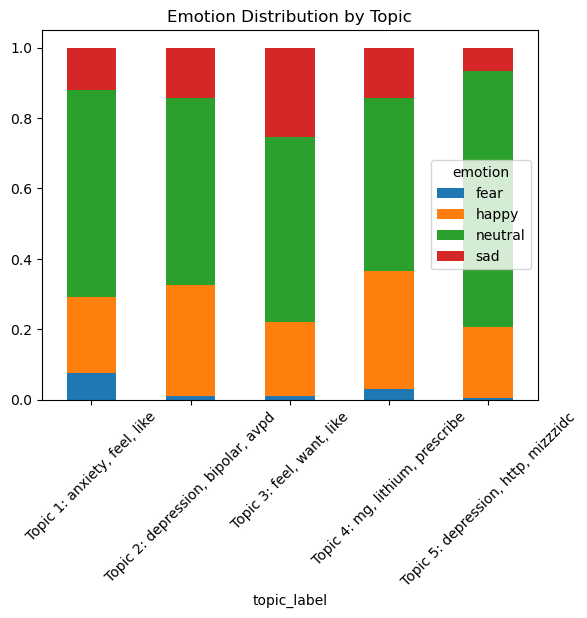

In [472]:
# Emotion by topic
emotion_by_topic = df.groupby('topic_label')['emotion'].value_counts(normalize=True).unstack(fill_value=0)
plt.figure(figsize=(12, 8))
emotion_by_topic.plot(kind='bar', stacked=True)
plt.title('Emotion Distribution by Topic')
plt.xticks(rotation=45)
plt.savefig('emotion_by_topic.png', bbox_inches='tight')
plt.show()

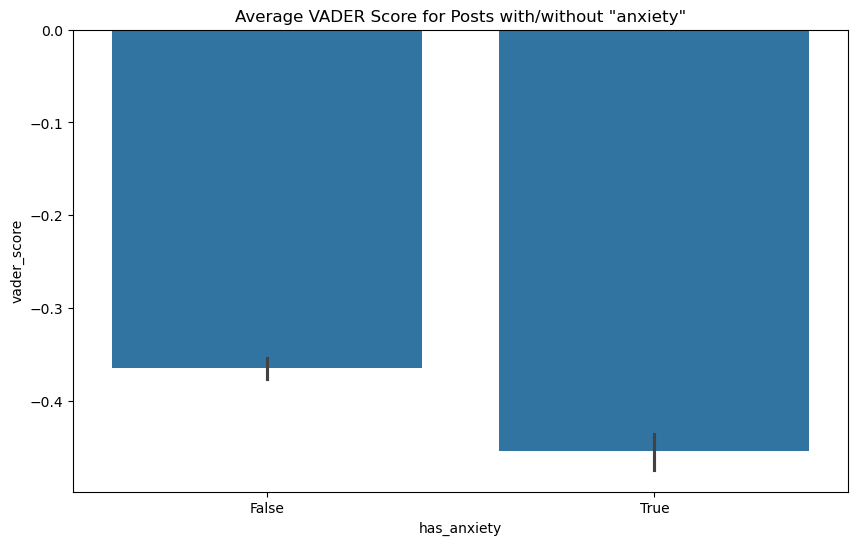

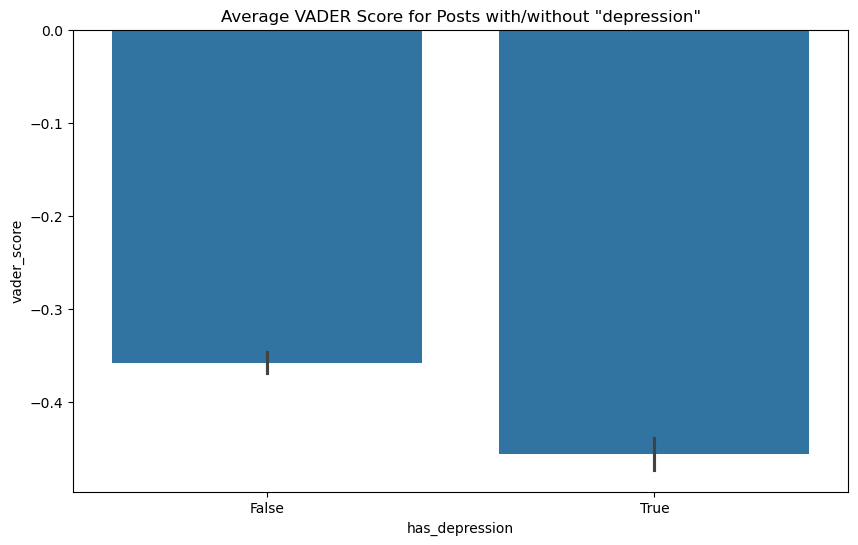

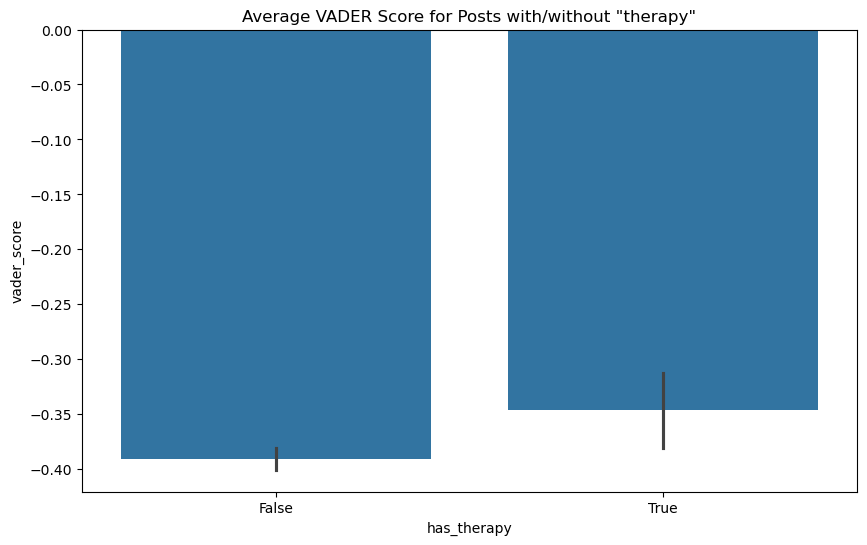

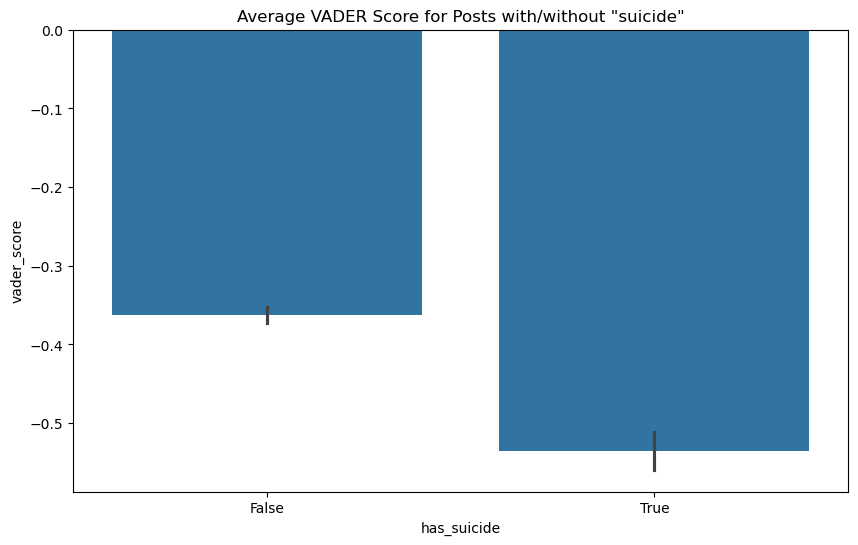

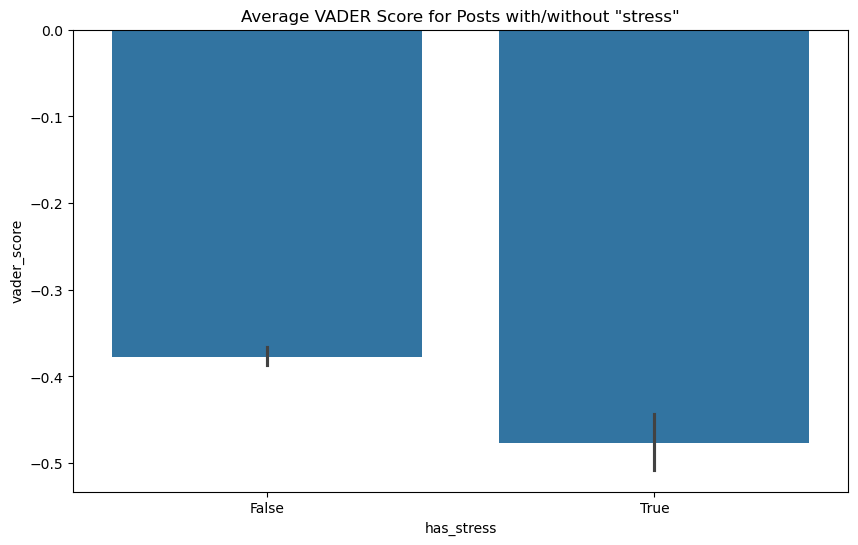

In [474]:
# Keyword-based analysis
keywords = ['anxiety', 'depression', 'therapy', 'suicide', 'stress']
for keyword in keywords:
    df[f'has_{keyword}'] = df['tokens_clean'].str.contains(keyword, case=False, na=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=f'has_{keyword}', y='vader_score')
    plt.title(f'Average VADER Score for Posts with/without "{keyword}"')
    plt.savefig(f'keyword_{keyword}_sentiment.png', bbox_inches='tight')
    plt.show()

In [488]:
# Keyword co-occurrence
co_occurrence_data = []
for k1 in keywords:
    for k2 in keywords:
        if k1 < k2:  # Avoid duplicates and self-pairs
            count = (df[f'has_{k1}'] & df[f'has_{k2}']).sum()
            co_occurrence_data.append({'keyword1': k1, 'keyword2': k2, 'count': count})
co_occurrence_df = pd.DataFrame(co_occurrence_data)
co_occurrence = co_occurrence_df.pivot_table(index='keyword1', columns='keyword2', values='count', fill_value=0)
# Ensure symmetry by adding mirrored pairs
co_occurrence = co_occurrence.combine_first(co_occurrence.T).fillna(0).astype(int)

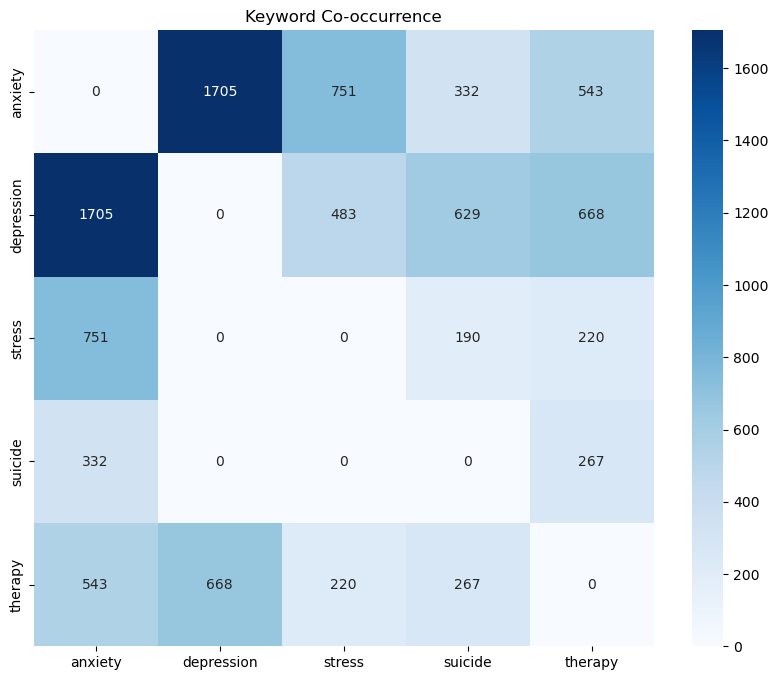

Step 5 completed: Visualizations saved


In [490]:
# Keyword co-occurrence
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='Blues')
plt.title('Keyword Co-occurrence')
plt.savefig('keyword_cooccurrence.png', bbox_inches='tight')
plt.show()
print("Step 5 completed: Visualizations saved")

In [478]:
# Step 6: Statistical Analysis
print("Step 6: Statistical Analysis")

Step 6: Statistical Analysis


In [480]:
# Chi-square test: Topic vs. Sentiment
chi2_sentiment, p_sentiment, _, _ = chi2_contingency(df.groupby(['topic_label', 'vader_sentiment']).size().unstack(fill_value=0))
print(f"Chi-square (Topic vs. Sentiment): chi2={chi2_sentiment:.2f}, p={p_sentiment:.4f}")

# Chi-square test: Topic vs. Emotion
chi2_emotion, p_emotion, _, _ = chi2_contingency(df.groupby(['topic_label', 'emotion']).size().unstack(fill_value=0))
print(f"Chi-square (Topic vs. Emotion): chi2={chi2_emotion:.2f}, p={p_emotion:.4f}")

# T-test: Anxiety vs. Therapy topics (assuming topic labels contain these terms)
anxiety_topic = df[df['topic_label'].str.contains('anxiety', case=False, na=False)]['vader_score']
therapy_topic = df[df['topic_label'].str.contains('therapy', case=False, na=False)]['vader_score']
if len(anxiety_topic) > 0 and len(therapy_topic) > 0:
    t_stat, p_ttest = ttest_ind(anxiety_topic, therapy_topic, equal_var=False)
    print(f"T-test (Anxiety vs. Therapy VADER Score): t={t_stat:.2f}, p={p_ttest:.4f}")
else:
    print("T-test skipped: Insufficient data for anxiety or therapy topics")

# Regression: Predict VADER score
X = pd.get_dummies(df[['topic_label', 'emotion'] + [f'has_{k}' for k in keywords]], drop_first=True)
y = df['vader_score']
reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)
coeffs = pd.Series(reg.coef_, index=X.columns)
print(f"Regression R²: {r2:.2f}")
print("Significant coefficients:\n", coeffs[coeffs.abs() > 0.1])

Chi-square (Topic vs. Sentiment): chi2=140.32, p=0.0000
Chi-square (Topic vs. Emotion): chi2=1060.97, p=0.0000
T-test skipped: Insufficient data for anxiety or therapy topics
Regression R²: 0.18
Significant coefficients:
 has_depression    -0.122136
has_suicide       -0.186752
has_stress        -0.112137
emotion_happy      0.876211
emotion_neutral    0.361359
dtype: float64


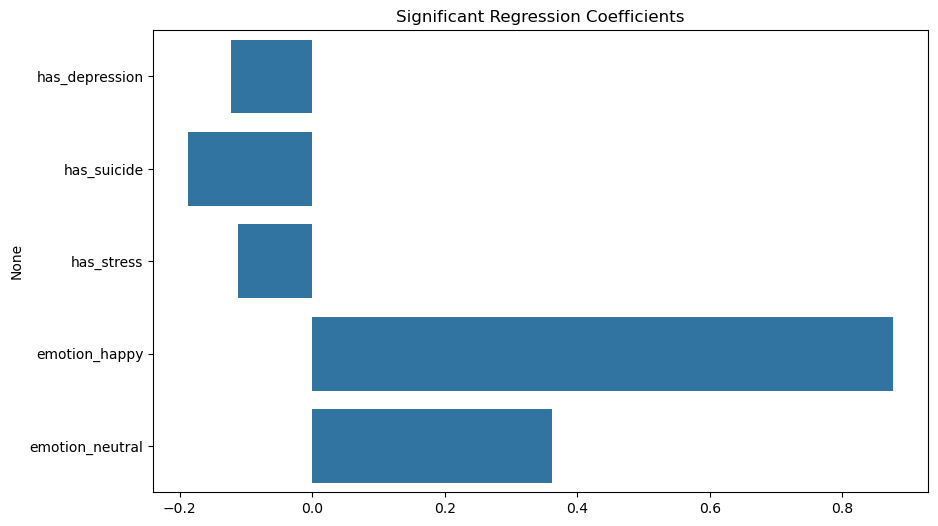

In [482]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x=coeffs[coeffs.abs() > 0.1].values, y=coeffs[coeffs.abs() > 0.1].index)
plt.title('Significant Regression Coefficients')
plt.savefig('regression_coeffs.png', bbox_inches='tight')
plt.show()

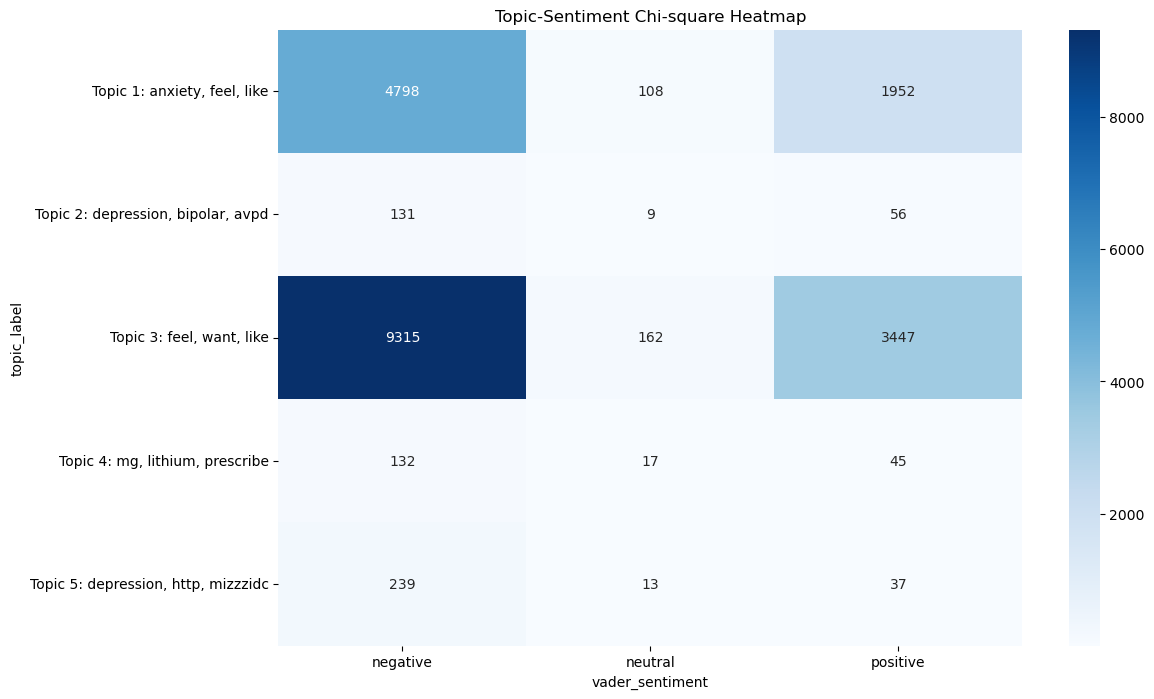

In [484]:
# Chi-square heatmap
chi2_data = df.groupby(['topic_label', 'vader_sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(chi2_data, annot=True, fmt='d', cmap='Blues')
plt.title('Topic-Sentiment Chi-square Heatmap')
plt.savefig('chi_square_heatmap.png', bbox_inches='tight')
plt.show()

In [486]:
# Save model summary
with open('docs/model_summary.txt', 'w') as f:
    f.write(f"Regression R²: {r2:.2f}\n")
    f.write("Significant coefficients:\n")
    f.write(str(coeffs[coeffs.abs() > 0.1]))
print("Step 6 completed: Statistical results saved")

Step 6 completed: Statistical results saved


In [492]:
# Step 7: Impact Analysis
print("Step 7: Impact Analysis")
# Quantify trends
sentiment_summary = df.groupby('topic_label')['vader_sentiment'].value_counts(normalize=True).unstack(fill_value=0)
emotion_summary = df.groupby('topic_label')['emotion'].value_counts(normalize=True).unstack(fill_value=0)
keyword_summary = {k: df[f'has_{k}'].mean() * 100 for k in keywords}

Step 7: Impact Analysis


<Figure size 1200x800 with 0 Axes>

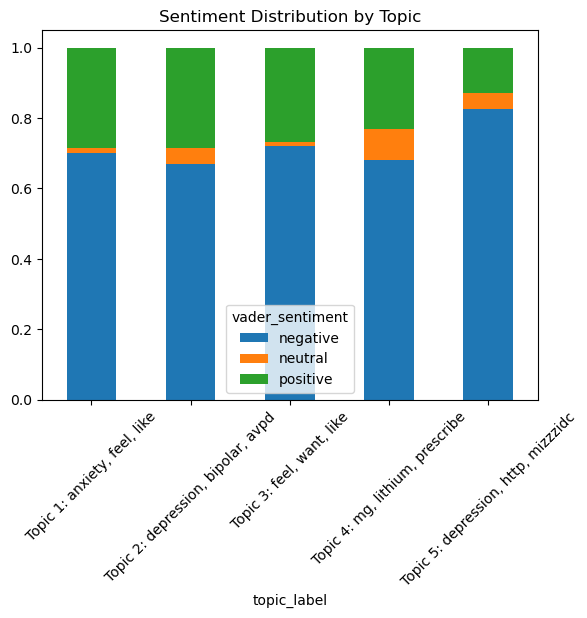

<Figure size 1200x800 with 0 Axes>

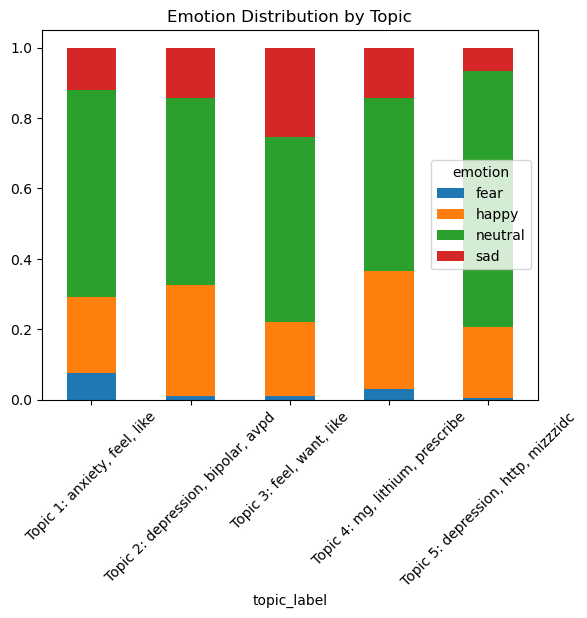

Step 7 completed: Impact analysis saved to docs/impact_analysis.md


In [494]:
# Visualizations
plt.figure(figsize=(12, 8))
sentiment_summary.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Topic')
plt.xticks(rotation=45)
plt.savefig('sentiment_distribution_by_topic.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
emotion_summary.plot(kind='bar', stacked=True)
plt.title('Emotion Distribution by Topic')
plt.xticks(rotation=45)
plt.savefig('emotion_distribution_by_topic.png', bbox_inches='tight')
plt.show()

print("Step 7 completed: Impact analysis saved to docs/impact_analysis.md")